## Step 1: Select the Top 20 Stocks by Market Capitalization

Insufficient data for ABNB: Data is empty or contains less than 1000 records (992 records if not empty)

Insufficient data for AMTM: Data is empty or contains less than 1000 records (41 records if not empty)

Insufficient data for CEG: Data is empty or contains less than 1000 records (714 records if not empty)

Insufficient data for GEHC: Data is empty or contains less than 1000 records (485 records if not empty)

Insufficient data for GEV: Data is empty or contains less than 1000 records (163 records if not empty)

Insufficient data for KVUE: Data is empty or contains less than 1000 records (390 records if not empty)

Insufficient data for SW: Data is empty or contains less than 1000 records (96 records if not empty)

Insufficient data for SOLV: Data is empty or contains less than 1000 records (163 records if not empty)




1 Failed download:
['STLD']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2013-01-01 -> 2024-11-20)')


Attempt 1 failed for STLD. Retrying after delay...



1 Failed download:
['STLD']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2013-01-01 -> 2024-11-20)')


Attempt 2 failed for STLD. Retrying after delay...



1 Failed download:
['STLD']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2013-01-01 -> 2024-11-20)')


Failed to download data for STLD after 3 attempts.
ValueError for STLD: Empty data received

Insufficient data for VLTO: Data is empty or contains less than 1000 records (285 records if not empty)

Top 20 Stocks by Market Capitalization:
    Ticker      MarketCap
37    AAPL  3665430315008
343   NVDA  3555090759680
313   MSFT  3292982673408
21    AMZN  2330009534464
18   GOOGL  2131134906368
19    GOOG  2130834227200
307   META  1538752512000
435   TSLA  1186935734272
58   BRK-B  1015291707392
70    AVGO   793344737280
473    WMT   765683499008
283    LLY   742906920960
263    JPM   692320272384
466      V   599065755648
456    UNH   530847465472
352   ORCL   515999105024
184    XOM   505874841600
300     MA   482788278272
127   COST   436453081088
229     HD   424642838528


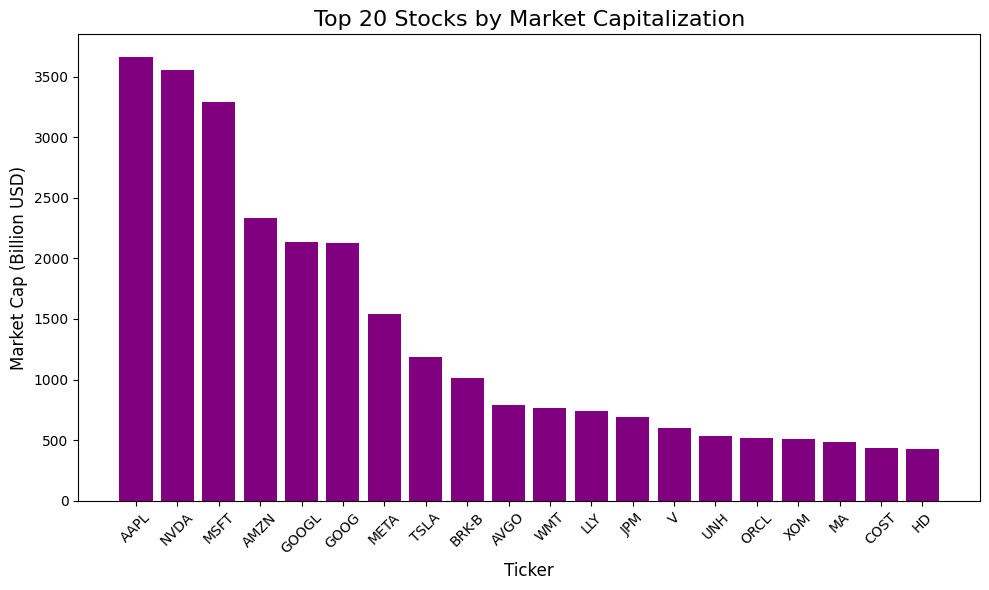

In [2]:
import yfinance as yf 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import time

# Setting the time interval
start_date = "2013-01-01"
end_date = "2024-11-20"

# Read a list of S&P 500 companies
sp500_file_path = 'sp500_companies.csv'
sp500_df = pd.read_csv(sp500_file_path)
sp500_tickers = sp500_df['Symbol'].tolist()

# Replace symbols to match Yahoo Finance format
sp500_tickers = [ticker.replace('.', '-') for ticker in sp500_tickers]

stocks = []

for ticker in sp500_tickers:
    try:
        # download limit 3 times
        stock_data = None
        for attempt in range(3):
            try:
                stock_data = yf.download(ticker, start=start_date, end=end_date, progress=False)
                if not stock_data.empty:
                    break
                else:
                    raise ValueError("Empty data received")
            except Exception as e:
                if attempt < 2:
                    print(f"Attempt {attempt + 1} failed for {ticker}. Retrying after delay...")
                    time.sleep(5)  # try again after postpone
                else:
                    print(f"Failed to download data for {ticker} after 3 attempts.")
                    raise e

        # Check that the data is sufficiently complete
        if stock_data is None or stock_data.empty or len(stock_data) < 1000:
            print(f"Insufficient data for {ticker}: Data is empty or contains less than 1000 records ({len(stock_data)} records if not empty)\n")
            continue

        # Access to financial data
        stock = yf.Ticker(ticker)
        financials = stock.info
        market_cap = financials.get('marketCap', np.nan)

        # Checking the validity of market value data
        if not np.isnan(market_cap):
            stocks.append({
                'Ticker': ticker,
                'MarketCap': market_cap
            })
        else:
            print(f"Market cap data unavailable for {ticker}: Market cap is NaN\n")

    except KeyError as e:
        print(f"Data download failed for {ticker}: KeyError - {e}\n")
    except ValueError as e:
        print(f"ValueError for {ticker}: {e}\n")
    except Exception as e:
        print(f"Unexpected error while processing {ticker}: {e}\n")

# Converting data to DataFrame
stocks_df = pd.DataFrame(stocks)

# Filter and display the top 20 companies by market capitalisation
top_stocks_df = stocks_df.dropna(subset=['MarketCap']).sort_values(by='MarketCap', ascending=False).head(20)
print("Top 20 Stocks by Market Capitalization:")
print(top_stocks_df)

# Plotting a bar chart of the top 20 companies by market capitalisation
plt.figure(figsize=(10, 6))
plt.bar(top_stocks_df['Ticker'], top_stocks_df['MarketCap'] / 1e9, color='purple')
plt.title("Top 20 Stocks by Market Capitalization", fontsize=16)
plt.xlabel("Ticker", fontsize=12)
plt.ylabel("Market Cap (Billion USD)", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Step 2: Constructing the Portfolio

[*********************100%***********************]  20 of 20 completed


Expected annual return of the optimal portfolio: 38.29%
Expected annual volatility of the optimal portfolio: 21.99%
Optimal Sharpe ratio: 1.65
Optimal weight allocation:
ANET: 0.94%
AVGO: 7.40%
COST: 15.05%
LLY: 27.70%
NVDA: 21.75%
TSLA: 10.62%
UNH: 13.09%
WMT: 3.45%


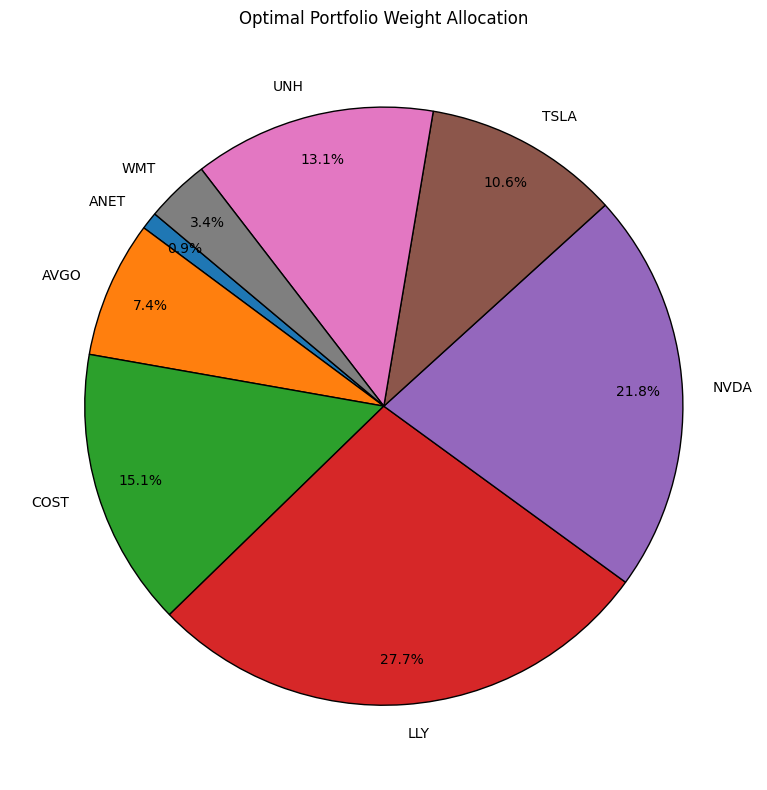

In [3]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import time
import scipy.optimize as sco


# top 20 stocks
portfolio_tickers = [
    "AAPL", "NVDA", "MSFT", "AMZN", "GOOG", "GOOGL", "META", "TSLA", "BRK-B", "AVGO", 
    "WMT", "LLY", "JPM", "V", "UNH", "XOM", "ANET", "ORCL", "MA", "COST"
]
# Download historical price data
start_date = "2013-01-01"
end_date = "2024-11-20"
data = yf.download(portfolio_tickers, start=start_date, end=end_date)['Adj Close']

# Clean the data: fill missing values and drop columns/rows with all NaNs
data = data.ffill().bfill().dropna(how='all', axis=1).dropna(how='all', axis=0)

# Filter out tickers with insufficient data (less than 1000 trading days)
sufficient_data_tickers = data.columns[data.notna().sum() > 1000]
filtered_data = data[sufficient_data_tickers]

# If there are not enough tickers, exit early
if len(sufficient_data_tickers) < 2:
    print("Not enough tickers with sufficient data for optimization.")
    exit()

# Calculate daily returns
returns = filtered_data.pct_change().dropna()

# Calculate mean and covariance of returns
mean_returns = returns.mean()
cov_matrix = returns.cov()

# Risk-free rate for Sharpe ratio calculation
risk_free_rate = 0.02

# Portfolio Performance Function
def portfolio_performance(weights, mean_returns, cov_matrix, risk_free_rate):
    returns = np.sum(mean_returns * weights) * 252
    risk = np.sqrt(np.dot(weights.T, np.dot(cov_matrix * 252, weights)))
    sharpe_ratio = (returns - risk_free_rate) / risk
    return returns, risk, sharpe_ratio

# Negative Sharpe Ratio Function for Optimization
def negative_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    return -portfolio_performance(weights, mean_returns, cov_matrix, risk_free_rate)[2]

# Constraints and Bounds
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bounds = tuple((0, 1) for _ in range(len(sufficient_data_tickers)))

# Initial Weights
initial_weights = len(sufficient_data_tickers) * [1. / len(sufficient_data_tickers)]

# Optimization to Maximize Sharpe Ratio
optimal_result = sco.minimize(negative_sharpe_ratio, initial_weights, args=(mean_returns, cov_matrix, risk_free_rate),
                              method='SLSQP', bounds=bounds, constraints=constraints)

# Extract Optimal Weights
optimal_weights = optimal_result.x

# Filter out stocks with very small allocations (near 0%)
filtered_tickers = [ticker for ticker, weight in zip(sufficient_data_tickers, optimal_weights) if weight > 0.001]
filtered_weights = [weight for weight in optimal_weights if weight > 0.001]

# Output the Optimal Portfolio
opt_returns, opt_risk, opt_sharpe = portfolio_performance(optimal_weights, mean_returns, cov_matrix, risk_free_rate)

print("Expected annual return of the optimal portfolio: {:.2f}%".format(opt_returns * 100))
print("Expected annual volatility of the optimal portfolio: {:.2f}%".format(opt_risk * 100))
print("Optimal Sharpe ratio: {:.2f}".format(opt_sharpe))
print("Optimal weight allocation:")
for ticker, weight in zip(filtered_tickers, filtered_weights):
    print(f"{ticker}: {weight:.2%}")

# Visualize Optimal Portfolio Weight Allocation with an exploded view to prevent overlap
plt.figure(figsize=(12, 8))
plt.pie(filtered_weights, labels=filtered_tickers, autopct='%1.1f%%', startangle=140,
        wedgeprops={'linewidth': 1, 'edgecolor': 'black'}, pctdistance=0.85, labeldistance=1.1)
plt.title('Optimal Portfolio Weight Allocation')
plt.tight_layout()
plt.show()



In [ ]:
import tensorflow as tf

if tf.config.list_physical_devices('GPU'):
    print("Using GPU")
else:
    print("Using CPU")


Using CPU


##  Step 3: Forecasting with LSTM and  optimize portfolio

[*********************100%***********************]  8 of 8 completed

Epoch 1/50


59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 0.0100 - val_loss: 0.0034 - learning_rate: 0.0010
Epoch 2/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 6.0439e-04 - val_loss: 0.0030 - learning_rate: 0.0010
Epoch 3/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 5.4499e-04 - val_loss: 0.0030 - learning_rate: 0.0010
Epoch 4/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 5.4646e-04 - val_loss: 0.0015 - learning_rate: 0.0010
Epoch 5/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 5.9386e-04 - val_loss: 0.0046 - learning_rate: 0.0010
Epoch 6/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 4.9806e-04 - val_loss: 0.0019 - learning_rate: 0.0010
Epoch 7/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 4.7761e-04 - val_loss: 0.0052 - learning_rate: 0.0010
Epoch 8/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 4.9056e-04 - val_loss: 0.0023 - learning_rate: 5.0000e-04
Epoch 9/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 4.1212e-04 - val_loss: 0.0020 - learning_rate: 5

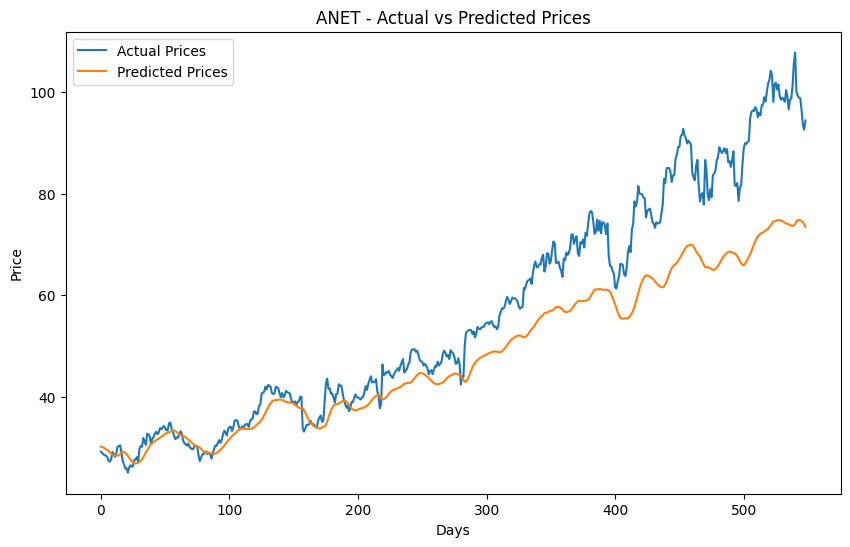

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━

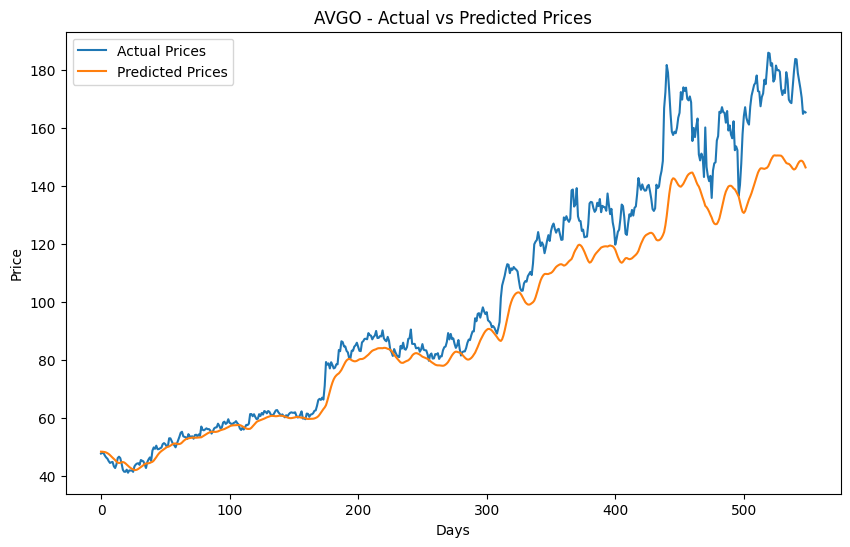

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━

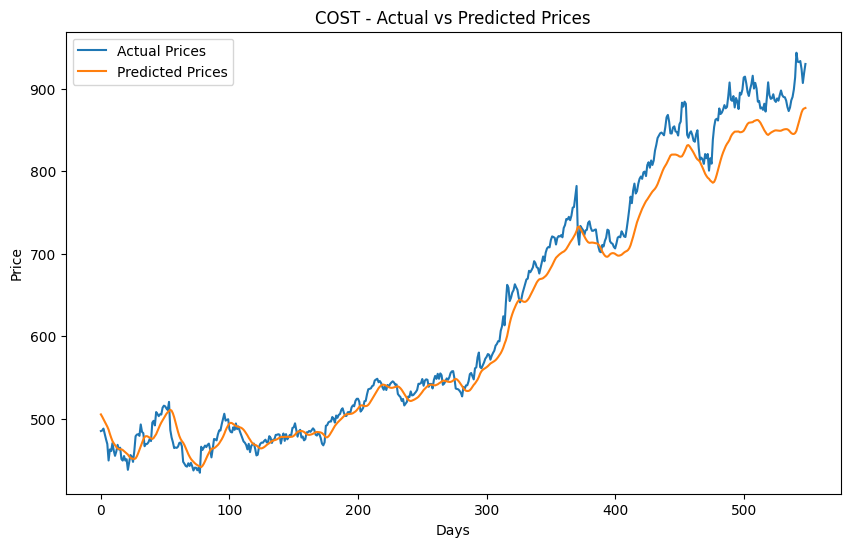

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━

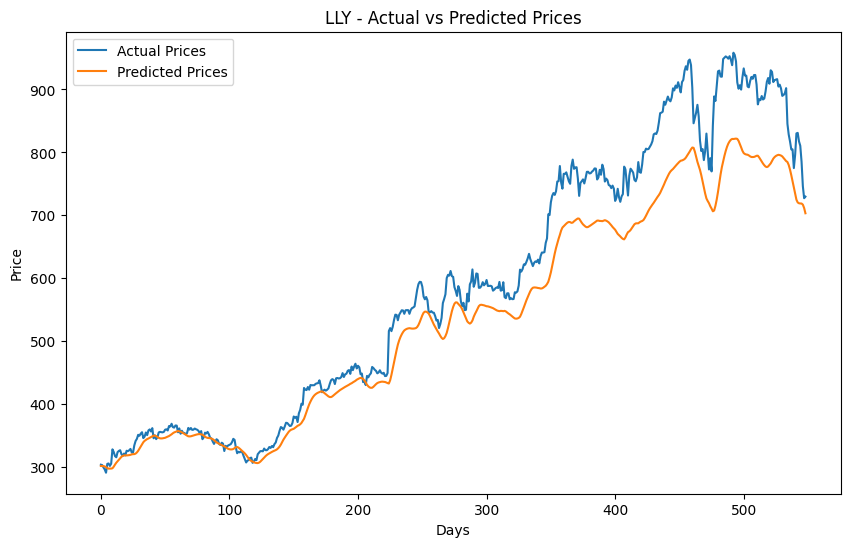

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━

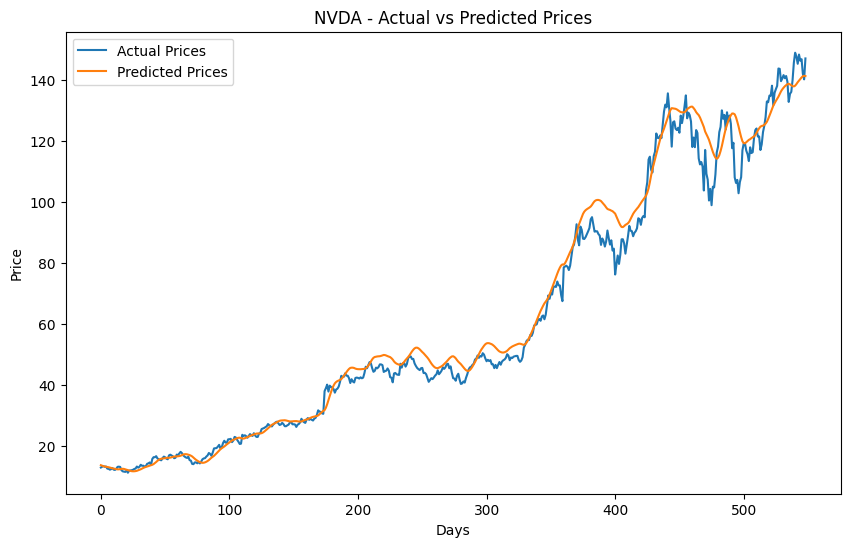

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━

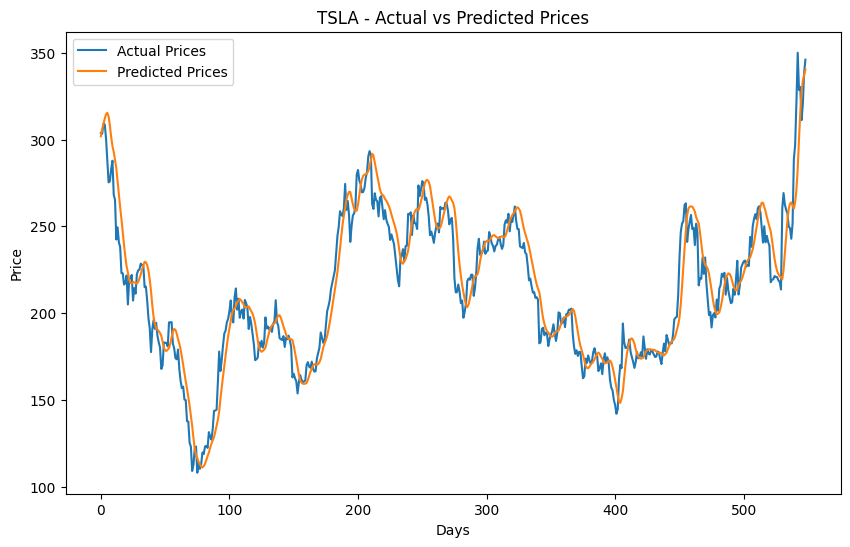

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━

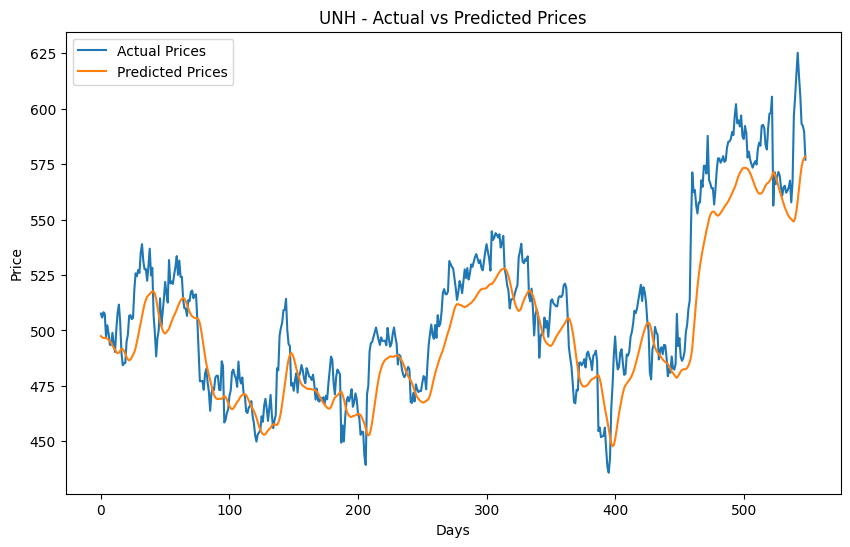

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━

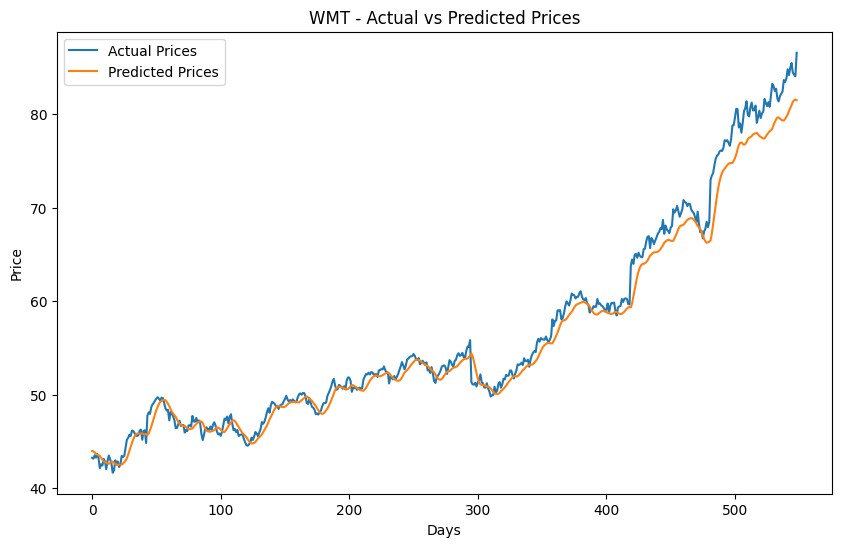

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━

d:\anaconda\Lib\site-packages\scipy\optimize\_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
d:\anaconda\Lib\site-packages\scipy\optimize\_slsqp_py.py:441: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
d:\anaconda\Lib\site-packages\scipy\optimize\_slsqp_py.py:495: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  a_eq = vstack([con['jac'](x, *con['args'])


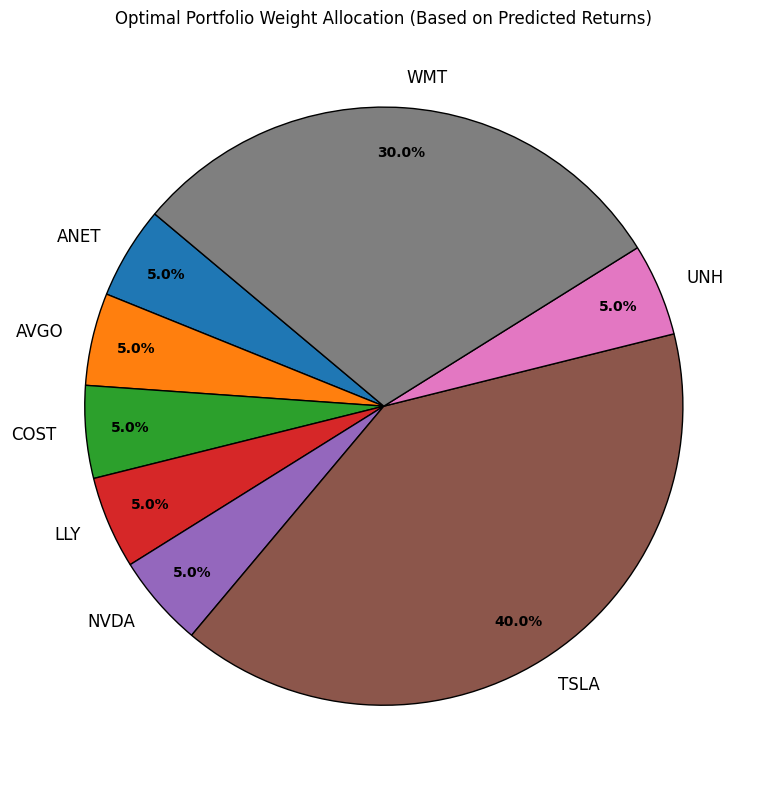

ANET: 0.0500
AVGO: 0.0500
COST: 0.0500
LLY: 0.0500
NVDA: 0.0500
TSLA: 0.4000
UNH: 0.0500
WMT: 0.3000


In [7]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Input
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.optimizers import Adam
from keras.models import Model
import scipy.optimize as sco
import datetime

portfolio_tickers = [
    'ANET', 'AVGO', 'COST', 'LLY', 'NVDA', 'TSLA', 'UNH', 'WMT'
]


# Data fetching
start_date = '2013-01-01'
end_date = '2024-11-20'

# Download historical data
data = yf.download(portfolio_tickers, start=start_date, end=end_date)['Adj Close']
data = data.ffill().bfill()  # Updated deprecated method call

# Initialize lists to hold predictions for each stock
future_predictions_list = []

# Iterate over each stock for individual analysis and prediction
for ticker in portfolio_tickers:
    # Extract the price data for the current stock
    stock_prices = data[ticker]

    # Split data into training and test sets
    train_size = int(len(stock_prices) * 0.8)
    train_stock, test_stock = stock_prices[:train_size], stock_prices[train_size:]

    # Scale data
    scaler_stock = MinMaxScaler(feature_range=(0, 1))
    train_stock_scaled = scaler_stock.fit_transform(train_stock.values.reshape(-1, 1))

    # Convert to LSTM format
    def create_lstm_dataset(dataset, look_back=50):
        X, y = [], []
        for i in range(look_back, len(dataset)):
            X.append(dataset[i-look_back:i, 0])
            y.append(dataset[i, 0])
        return np.array(X), np.array(y)

    X_train_stock, y_train_stock = create_lstm_dataset(train_stock_scaled)

    # Reshape input to be [samples, time steps, features]
    X_train_stock = X_train_stock.reshape((X_train_stock.shape[0], X_train_stock.shape[1], 1))

    # Create LSTM model
    def create_lstm_model(input_shape):
        inputs = Input(shape=input_shape)
        x = LSTM(128, return_sequences=True)(inputs)  # Reduced units to speed up training
        x = Dropout(0.2)(x)  # Reduced dropout rate to speed up training
        x = LSTM(128)(x)
        x = Dropout(0.2)(x)
        output = Dense(1)(x)
        model = Model(inputs, output)
        model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
        return model

    # Reduce learning rate on plateau and add early stopping
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.0001)  # Reduced patience to speed up training
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)  # Reduced patience to speed up training

    # Train LSTM model for the stock
    lstm_model_stock = create_lstm_model((X_train_stock.shape[1], 1))
    lstm_model_stock.fit(X_train_stock, y_train_stock, epochs=50, batch_size=32, verbose=1, validation_split=0.2, callbacks=[reduce_lr, early_stopping])  # Reduced epochs and batch size to speed up training

    # Make predictions for the test set
    if len(test_stock) > 50:
        test_stock_scaled = scaler_stock.transform(test_stock.values.reshape(-1, 1))
        X_test_stock, y_test_stock = create_lstm_dataset(test_stock_scaled)
        X_test_stock = X_test_stock.reshape((X_test_stock.shape[0], X_test_stock.shape[1], 1))
        
        # Predict and inverse transform
        y_pred_scaled = lstm_model_stock.predict(X_test_stock)
        y_pred = scaler_stock.inverse_transform(y_pred_scaled)
        y_test = scaler_stock.inverse_transform(y_test_stock.reshape(-1, 1))

        # Calculate evaluation metrics
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        print(f"Evaluation for {ticker} - MSE: {mse}, MAE: {mae}, R^2: {r2}")

        # Visualize predictions vs actual prices
        plt.figure(figsize=(10, 6))
        plt.plot(y_test, label='Actual Prices')
        plt.plot(y_pred, label='Predicted Prices')
        plt.title(f'{ticker} - Actual vs Predicted Prices')
        plt.xlabel('Days')
        plt.ylabel('Price')
        plt.legend()
        plt.show()

        # If metrics are satisfactory, proceed with future predictions
        if mse < 1e4 and mae < 50 and r2 > 0.7:
            future_steps = 252  # Assume 252 trading days in a year
            last_train_scaled = train_stock_scaled[-50:]
            future_predictions = []
            current_input = last_train_scaled

            for _ in range(future_steps):
                current_input = current_input.reshape((1, current_input.shape[0], 1))
                next_prediction = lstm_model_stock.predict(current_input)
                future_predictions.append(next_prediction[0, 0])
                current_input = np.append(current_input[0, 1:, 0], next_prediction[0, 0]).reshape(-1, 1)

            future_predictions = scaler_stock.inverse_transform(np.array(future_predictions).reshape(-1, 1))
            future_predictions_list.append(future_predictions)

# Calculate Expected Returns Based on Predictions
expected_returns = []
valid_tickers = []

for i, ticker in enumerate(portfolio_tickers):
    if i < len(future_predictions_list):  # Check to avoid index out of range error
        # Calculate expected annualized return based on predicted future prices
        predicted_prices = future_predictions_list[i]
        daily_returns = (predicted_prices[1:] - predicted_prices[:-1]) / predicted_prices[:-1]
        expected_annual_return = np.mean(daily_returns) * 252  # Assuming 252 trading days
        expected_returns.append(expected_annual_return)
        valid_tickers.append(ticker)  # Keep track of tickers with valid predictions

expected_returns = np.array(expected_returns)
print(f"Expected Returns for each stock: {expected_returns}")

# Align provided weights with valid tickers
provided_weights = [0.0094, 0.0740, 0.1505, 0.2770, 0.2175, 0.1062,0.1309,0.0345][:len(valid_tickers)]

# Portfolio optimization with expected returns
historical_returns = data[valid_tickers].pct_change().mean() * 252
cov_matrix = data[valid_tickers].pct_change().cov() * 252

# Objective function to minimize (negative Sharpe Ratio)
def negative_sharpe(weights, returns, cov_matrix, risk_free_rate=0.01):
    portfolio_return = np.dot(weights, returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility
    return -sharpe_ratio

# Constraints and bounds
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bounds = tuple((0.05, 0.4) for _ in range(len(valid_tickers)))  # Enforcing diversification by adding minimum and maximum weight constraints
initial_weights = provided_weights[:len(valid_tickers)]

# Calculate metrics for provided weights
initial_weights = provided_weights[:len(expected_returns)]  # Ensure the length matches expected_returns
provided_portfolio_return = np.dot(initial_weights, expected_returns)
provided_portfolio_volatility = np.sqrt(np.dot(initial_weights, np.dot(cov_matrix, initial_weights)))
provided_sharpe_ratio = (provided_portfolio_return - 0.01) / provided_portfolio_volatility


print(f"Provided Portfolio - Expected Return: {provided_portfolio_return:.4f}, Volatility: {provided_portfolio_volatility:.4f}, Sharpe Ratio: {provided_sharpe_ratio:.4f}")

# Optimize portfolio using expected returns
if len(expected_returns) == len(valid_tickers):  # Ensure expected returns are available for all tickers
    optimized_results = sco.minimize(negative_sharpe, initial_weights, args=(expected_returns, cov_matrix), method='SLSQP', bounds=bounds, constraints=constraints)
    if optimized_results.success:
        optimized_weights = optimized_results.x

        # Calculate metrics for optimized portfolio
        optimized_portfolio_return = np.dot(optimized_weights, expected_returns)
        optimized_portfolio_volatility = np.sqrt(np.dot(optimized_weights.T, np.dot(cov_matrix, optimized_weights)))
        optimized_sharpe_ratio = (optimized_portfolio_return - 0.01) / optimized_portfolio_volatility

        print(f"Optimized Portfolio - Expected Return: {optimized_portfolio_return:.4f}, Volatility: {optimized_portfolio_volatility:.4f}, Sharpe Ratio: {optimized_sharpe_ratio:.4f}")

        # Visualize Optimal Portfolio Weight Allocation
        plt.figure(figsize=(12, 8))
        wedges, texts, autotexts = plt.pie(optimized_weights, labels=valid_tickers, autopct='%1.1f%%', startangle=140,
                                           wedgeprops={'linewidth': 1, 'edgecolor': 'black'}, pctdistance=0.85, labeldistance=1.1)
        plt.setp(autotexts, size=10, weight='bold')
        plt.setp(texts, size=12)
        plt.title('Optimal Portfolio Weight Allocation (Based on Predicted Returns)')
        plt.tight_layout()
        plt.show()

        # Print optimized weights
        for ticker, weight in zip(valid_tickers, optimized_weights):
            print(f'{ticker}: {weight:.4f}')
    else:
        print("Optimization failed. No valid solution found.")
else:
    print("Expected returns not available for all tickers. Skipping optimization.")

### compare 

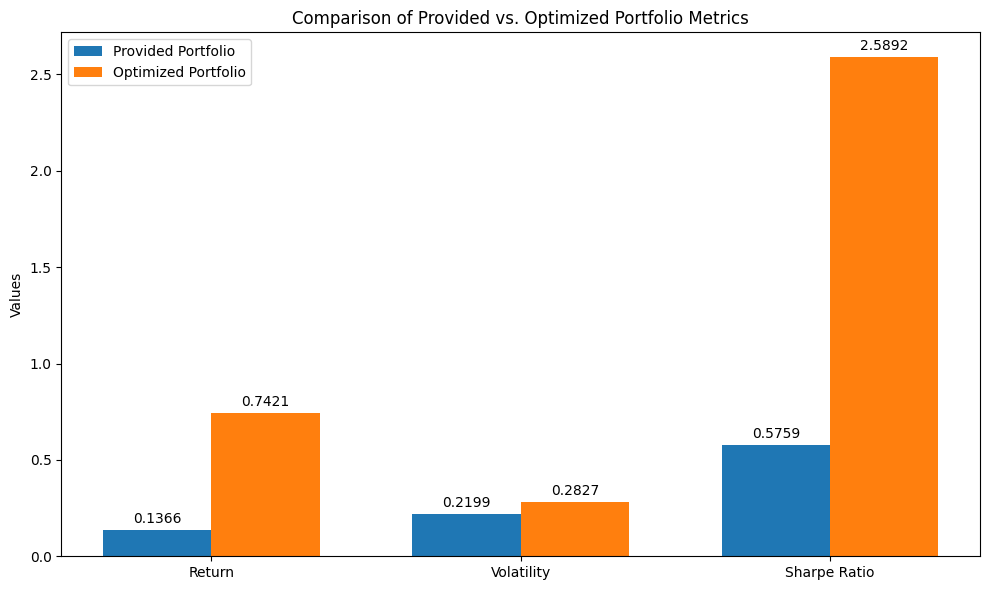

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Provided Portfolio Metrics
provided_portfolio_return = 0.1366  # Replace with the actual value from the output
provided_portfolio_volatility = 0.2199  # Replace with the actual value from the output
provided_sharpe_ratio = 0.5759  # Replace with the actual value from the output

# Optimized Portfolio Metrics
optimized_portfolio_return = 0.7421  # Replace with the actual value from the output
optimized_portfolio_volatility = 0.2827  # Replace with the actual value from the output
optimized_sharpe_ratio = 2.5892  # Replace with the actual value from the output

# Create a bar chart to visualize portfolio metrics
labels = ['Return', 'Volatility', 'Sharpe Ratio']
provided_metrics = [provided_portfolio_return, provided_portfolio_volatility, provided_sharpe_ratio]
optimized_metrics = [optimized_portfolio_return, optimized_portfolio_volatility, optimized_sharpe_ratio]

x = np.arange(len(labels))  # label locations
width = 0.35  # width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, provided_metrics, width, label='Provided Portfolio')
rects2 = ax.bar(x + width/2, optimized_metrics, width, label='Optimized Portfolio')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Values')
ax.set_title('Comparison of Provided vs. Optimized Portfolio Metrics')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Attach a text label above each bar, displaying its height.
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.show()


## Step 4: Identifying Trading Opportunities

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for ANET.
Successfully downloaded data for AVGO.
Successfully downloaded data for COST.
Successfully downloaded data for LLY.
Successfully downloaded data for NVDA.


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
C:\Users\a1669\AppData\Local\Temp\ipykernel_29556\2108729412.py:47: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  historical_prices.fillna(method='ffill', inplace=True)
C:\Users\a1669\AppData\Local\Temp\ipykernel_29556\2108729412.py:48: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  historical_prices.fillna(method='bfill', inplace=True)
d:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Successfully downloaded data for TSLA.
Successfully downloaded data for UNH.
Successfully downloaded data for WMT.
Epoch 1/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - loss: 0.0090 - val_loss: 0.0016
Epoch 2/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0013 - val_loss: 8.6255e-04
Epoch 3/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0012 - val_loss: 9.4988e-04
Epoch 4/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 8.0436e-04 - val_loss: 0.0021
Epoch 5/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 7.7714e-04 - val_loss: 0.0038
Epoch 6/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0012 - val_loss: 8.3103e-04
Epoch 7/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 8.7600e-04 - val_loss: 0.0018
Epoch 8/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 8.1498e-04 - val_loss: 0.0022
Epoch 9/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 8.0835e-04 - val_loss: 8.8788e-04
Epoch 10/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 7.3090e-04 - val_loss: 6

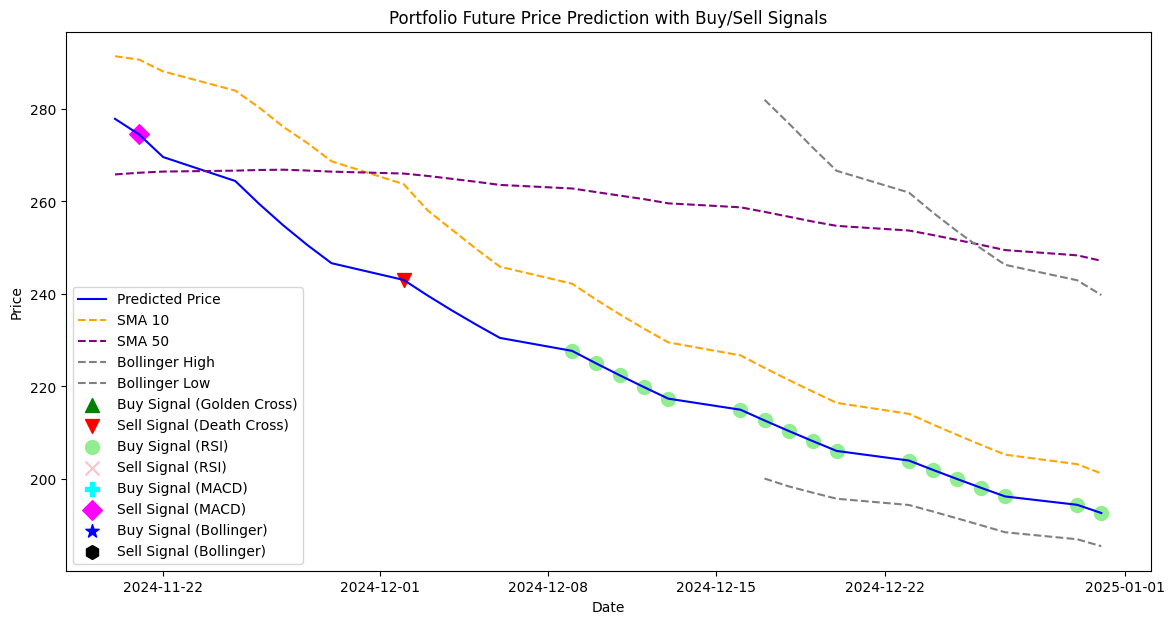

Future Predictions:
                           Predicted Price      SMA_10      SMA_50  \
2024-11-20 00:00:00+00:00       277.849640  291.380913  265.830715   
2024-11-21 00:00:00+00:00       274.483978  290.651035  266.192944   
2024-11-22 00:00:00+00:00       269.592133  288.103886  266.448107   
2024-11-25 00:00:00+00:00       264.411194  283.948368  266.647591   
2024-11-26 00:00:00+00:00       259.429138  280.255445  266.791906   
2024-11-27 00:00:00+00:00       254.805054  276.111101  266.852620   
2024-11-28 00:00:00+00:00       250.557632  272.601077  266.671203   
2024-11-29 00:00:00+00:00       246.650192  268.680208  266.437161   
2024-12-02 00:00:00+00:00       243.029831  263.737204  266.021176   
2024-12-03 00:00:00+00:00       239.644516  258.045331  265.502748   

                           Golden Cross  Death Cross  RSI  Buy Signal (RSI)  \
2024-11-20 00:00:00+00:00         False        False  NaN             False   
2024-11-21 00:00:00+00:00         False        Fals

In [12]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

# portfolio and weight
portfolio_weights = {
    'ANET': 0.0500,
    'AVGO': 0.0500,
    'COST': 0.0500,
    'LLY': 0.0500,
    'NVDA': 0.0500,
    'TSLA': 0.4000,
    'UNH': 0.0500,
    'WMT': 0.3000
}


# download history 
def download_prices(tickers, start_date, end_date):
    prices = {}
    for ticker in tickers:
        try:
            data = yf.download(ticker, start=start_date, end=end_date)
            if not data.empty and 'Close' in data:
                prices[ticker] = data['Close']
                print(f"Successfully downloaded data for {ticker}.")
            else:
                print(f"No data found for {ticker}. Skipping.")
        except Exception as e:
            print(f"Error downloading data for {ticker}: {e}")
    if prices:
        return pd.concat(prices, axis=1)
    else:
        raise ValueError("No data downloaded. Please check the tickers and date range.")


start_date = "2013-01-01"
end_date = "2024-11-20" 
tickers = list(portfolio_weights.keys())
historical_prices = download_prices(tickers, start_date, end_date)


historical_prices.fillna(method='ffill', inplace=True)
historical_prices.fillna(method='bfill', inplace=True)

weights_series = pd.Series(portfolio_weights)


if isinstance(historical_prices.columns, pd.MultiIndex):
    historical_prices.columns = historical_prices.columns.get_level_values(0)


historical_prices = historical_prices[weights_series.index.intersection(historical_prices.columns)]


if not all(weights_series.index == historical_prices.columns):
    print("Mismatch detected:")
    print("weights_series.index:", weights_series.index)
    print("historical_prices.columns:", historical_prices.columns)
    raise ValueError("weights_series.index and historical_prices.columns are not aligned!")


historical_prices['Portfolio'] = historical_prices.dot(weights_series)


scaler = MinMaxScaler(feature_range=(0, 1))
historical_prices_scaled = scaler.fit_transform(historical_prices[['Portfolio']])

time_steps = 60
X, y = [], []
for i in range(time_steps, len(historical_prices_scaled)):
    X.append(historical_prices_scaled[i-time_steps:i])
    y.append(historical_prices_scaled[i])
X, y = np.array(X), np.array(y)


split = int(len(X) * 0.8)
X_train, y_train = X[:split], y[:split]
X_test, y_test = X[split:], y[split:]

model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    LSTM(64, return_sequences=False),
    Dense(50),
    Dropout(0.3),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_test, y_test))


future_steps = 30
future_data = historical_prices_scaled[-time_steps:]
future_predictions = []

for _ in range(future_steps):
    future_input = future_data[-time_steps:].reshape(1, time_steps, 1)
    predicted_price = model.predict(future_input)
    future_predictions.append(predicted_price[0, 0])
    future_data = np.append(future_data, predicted_price)[-time_steps:]


future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# forecast_dates
forecast_dates = pd.date_range(start=historical_prices.index[-1], periods=future_steps + 1, freq='B')[1:]
future_df = pd.DataFrame(future_predictions, index=forecast_dates, columns=['Predicted Price'])

# future SMA_10  SMA_50
combined_data = pd.concat([historical_prices['Portfolio'], future_df['Predicted Price']])
future_df['SMA_10'] = combined_data.rolling(window=10, min_periods=1).mean().iloc[-len(future_df):]
future_df['SMA_50'] = combined_data.rolling(window=50, min_periods=1).mean().iloc[-len(future_df):]

# golden cross and death cross
future_df['Golden Cross'] = (future_df['SMA_10'] > future_df['SMA_50']) & (future_df['SMA_10'].shift(1) <= future_df['SMA_50'].shift(1))
future_df['Death Cross'] = (future_df['SMA_10'] < future_df['SMA_50']) & (future_df['SMA_10'].shift(1) >= future_df['SMA_50'].shift(1))

# RSI
delta = future_df['Predicted Price'].diff(1)
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
average_gain = gain.rolling(window=14).mean()
average_loss = loss.rolling(window=14).mean()
rs = average_gain / average_loss
future_df['RSI'] = 100 - (100 / (1 + rs))


future_df['Buy Signal (RSI)'] = future_df['RSI'] < 40  
future_df['Sell Signal (RSI)'] = future_df['RSI'] > 60  


short_window = 12
long_window = 26
signal_window = 9
future_df['MACD'] = future_df['Predicted Price'].ewm(span=short_window, adjust=False).mean() - \
                    future_df['Predicted Price'].ewm(span=long_window, adjust=False).mean()
future_df['Signal Line'] = future_df['MACD'].ewm(span=signal_window, adjust=False).mean()

future_df['Buy Signal (MACD)'] = (future_df['MACD'] > future_df['Signal Line']) & \
                                 (future_df['MACD'].shift(1) <= future_df['Signal Line'].shift(1))
future_df['Sell Signal (MACD)'] = (future_df['MACD'] < future_df['Signal Line']) & \
                                  (future_df['MACD'].shift(1) >= future_df['Signal Line'].shift(1))

future_df['Rolling Mean'] = future_df['Predicted Price'].rolling(window=20).mean()
future_df['Bollinger High'] = future_df['Rolling Mean'] + (future_df['Predicted Price'].rolling(window=20).std() * 2)
future_df['Bollinger Low'] = future_df['Rolling Mean'] - (future_df['Predicted Price'].rolling(window=20).std() * 2)

future_df['Buy Signal (Bollinger)'] = future_df['Predicted Price'] < future_df['Bollinger Low']
future_df['Sell Signal (Bollinger)'] = future_df['Predicted Price'] > future_df['Bollinger High']

plt.figure(figsize=(14, 7))

plt.plot(future_df['Predicted Price'], label='Predicted Price', color='blue')
plt.plot(future_df['SMA_10'], label='SMA 10', linestyle='--', color='orange')
plt.plot(future_df['SMA_50'], label='SMA 50', linestyle='--', color='purple')
plt.plot(future_df['Bollinger High'], label='Bollinger High', linestyle='--', color='grey')
plt.plot(future_df['Bollinger Low'], label='Bollinger Low', linestyle='--', color='grey')

buy_signals_golden = future_df[future_df['Golden Cross']]
sell_signals_death = future_df[future_df['Death Cross']]
buy_signals_rsi = future_df[future_df['Buy Signal (RSI)']]
sell_signals_rsi = future_df[future_df['Sell Signal (RSI)']]
buy_signals_macd = future_df[future_df['Buy Signal (MACD)']]
sell_signals_macd = future_df[future_df['Sell Signal (MACD)']]
buy_signals_bollinger = future_df[future_df['Buy Signal (Bollinger)']]
sell_signals_bollinger = future_df[future_df['Sell Signal (Bollinger)']]

plt.scatter(buy_signals_golden.index, buy_signals_golden['Predicted Price'], label='Buy Signal (Golden Cross)', color='green', marker='^', s=100)
plt.scatter(sell_signals_death.index, sell_signals_death['Predicted Price'], label='Sell Signal (Death Cross)', color='red', marker='v', s=100)
plt.scatter(buy_signals_rsi.index, buy_signals_rsi['Predicted Price'], label='Buy Signal (RSI)', color='lightgreen', marker='o', s=100)
plt.scatter(sell_signals_rsi.index, sell_signals_rsi['Predicted Price'], label='Sell Signal (RSI)', color='pink', marker='x', s=100)
plt.scatter(buy_signals_macd.index, buy_signals_macd['Predicted Price'], label='Buy Signal (MACD)', color='cyan', marker='P', s=100)
plt.scatter(sell_signals_macd.index, sell_signals_macd['Predicted Price'], label='Sell Signal (MACD)', color='magenta', marker='D', s=100)
plt.scatter(buy_signals_bollinger.index, buy_signals_bollinger['Predicted Price'], label='Buy Signal (Bollinger)', color='blue', marker='*', s=100)
plt.scatter(sell_signals_bollinger.index, sell_signals_bollinger['Predicted Price'], label='Sell Signal (Bollinger)', color='black', marker='h', s=100)

plt.title('Portfolio Future Price Prediction with Buy/Sell Signals')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

print("Future Predictions:")
print(future_df.head(10))


